# Off-line evaluation Aftenposten article recommendations

Let $i$, $u$ and $k$ represent an item, user, and topic or category respectively, then $P(i | u)$
is the probability of user $u$ clicking on an item. 

Click events $r_{u, i} = 1 $ if user $u$ clicked on $i$

## Popularity model

$$ P(i | u) = P(i) \propto \sum_u r_{u,i} $$

## Pop by category model

 * Articles popularity

$$ P(i) $$

 * Articles as mixture of categories (from the content metadata)

$$ P(k | i) $$

 * User as mixture of categories (from the clicks)

$$ P(k | u) = \sum_{u, i} \mathbb{1}( \text{category}(i) = k) \ r_{u, i} $$

$$ P(i | u) = \sum_k P(i | k) P(k | u) = \sum_k \frac{ P(i) }{ P(k)} P(k | i) P(k | u) $$

So a user preference towards an item is proportional to the item's overall popularity and the user's preference towards the article's categories.

Let's assume $P(k)$ are equal for all categories. See for [Topic Modeling for Personalized
Recommendation of Volatile Items](http://www.lix.polytechnique.fr/~maks/papers/recommend.pdf) for more generative model around topics, users and items.

See implementation (https://github.schibsted.io/guillaume-allain/recs/blob/master/recs/models/history.py) and tests (https://github.schibsted.io/guillaume-allain/recs/blob/master/recs/test/models/test_history.py)

## Events and metadata

In [1]:
import pandas as pd
import numpy as np

events_path = "~/Data/collapsed_events_30_days.csv"

user_events = pd.read_csv(events_path, header=None, names=['ts', 'type', 'user', 'item'], parse_dates=['ts'])
mask = user_events['item'] != 'frontpage'
user_events = user_events[mask]
user_events['item'] = user_events['item'].astype('int64')

print("{} views from {} x {} user/articles from {} to {}".format(
        user_events.shape[0],
        user_events.user.unique().shape,
        user_events.item.unique().shape,
        user_events.ts.min(),
        user_events.ts.max()))

2305542 views from (138609,) x (38952,) user/articles from 2015-09-16 08:03:58 to 2015-10-15 23:59:36


In [2]:
print user_events.dtypes
user_events.head()

ts      datetime64[ns]
type            object
user             int64
item             int64
dtype: object


,ts,type,user,item
0,2015-09-30 17:04:52,View,3715244,8185208
2,2015-09-25 08:22:56,View,3532581,8179217
3,2015-10-07 18:56:51,View,3530156,8192364
4,2015-10-02 21:51:30,View,1751789,8182586
5,2015-09-23 05:46:57,View,2707306,605590


In [3]:
from recs import dataio

dataio.load_article_categories_df().head()

,nyheter,lordag (da),byutvikling,anmeldelser,musikk,eksperter,madsen,lund,debatt,okonomi,...,leder,forsiden,anbefalinger,haugen,onsdag (da),torsdag (da),k-magasinet,fremskrittspartiet,kaffe,blogg
8188176,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8198524,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8200641,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
8186447,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8188828,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [4]:
main_categories = ['innenriks', 'verden', 'meninger', 'osloby', 'kultur', 'okonomi']
article_from_main_categories = dataio.load_article_categories_df()[main_categories]

user_events_with_cat = pd.merge(
    user_events,
    article_from_main_categories.reset_index(),
    left_on='item', right_on='index', how='inner')

print user_events_with_cat.shape
user_events_with_cat.head()

(719799, 11)


,ts,type,user,item,index,innenriks,verden,meninger,osloby,kultur,okonomi
0,2015-10-07 18:56:51,View,3530156,8192364,8192364,1,0,0,0,0,0
1,2015-10-07 20:29:59,View,4730292,8192364,8192364,1,0,0,0,0,0
2,2015-10-07 18:21:15,View,3701590,8192364,8192364,1,0,0,0,0,0
3,2015-10-08 06:15:17,View,406649,8192364,8192364,1,0,0,0,0,0
4,2015-10-08 20:12:49,View,3821803,8192364,8192364,1,0,0,0,0,0


## Train and test splits

Articles have rarely a lifetime greater than a day

  $\Rightarrow$ it doesn't make sense to test a model against a test period bigger than a day
   
  $\Rightarrow$ train and test splits disjoint but set on the same day (cut-off at noon) 
  
  $\Rightarrow$ train data from the past days is useful to model user preferences towards categories (but could also vary over time), but useless to calculate popularity
 

In [64]:
from datetime import datetime, timedelta

def train_test_splits(user_item_ts_df, cut_off_dt):
    def to_end_of_dt(dt):
        return datetime(dt.year, dt.month, dt.day) + timedelta(days=1)
    
    train_mask = user_item_ts_df.ts <= cut_off_dt
    after_test_day_mask = user_item_ts_df.ts > to_end_of_dt(cut_off_dt)
    return user_item_ts_df.ix[train_mask,:], user_item_ts_df.ix[np.logical_not(np.logical_or(train_mask, after_test_day_mask)),:]

train_df, test_df = train_test_splits(user_events_with_cat, cut_off_dt=datetime(2015, 10, 15, 12, 0, 0))
print(user_events.shape)
print(train_df.shape)
print(test_df.shape)

(2305542, 4)
(690461, 11)
(29338, 11)


## Recommendations examples

In [14]:
from recs.models import pop

pers_model = pop.PopModel.fit(train_df)
pers_model.recs(users=[[3530156]], topn=5)

,item,user
0,8192223,3530156
1,8202632,3530156
2,8203941,3530156
3,8200902,3530156
4,8202514,3530156


In [32]:
from recs.models import history

pers_model = history.MixtureOfCategoryModel.fit(train_df)
print(pers_model.user_category_probs.loc[3530156])
print(pers_model.item_category_probs.loc[8192223])

pers_model.recs([3530156], topn=5)

innenriks    0.409091
verden       0.090909
meninger     0.045455
osloby       0.409091
kultur       0.045455
okonomi      0.000000
Name: 3530156, dtype: float64
innenriks    0
verden       0
meninger     0
osloby       0
kultur       0
okonomi      1
Name: 8192223, dtype: float64


,item,score,user
0,8202632,0.022505,3530156
1,8202714,0.014817,3530156
2,8203608,0.014332,3530156
3,8203789,0.012251,3530156
4,8201533,0.011601,3530156


## Evaluation

In [152]:
from recs.evaluation import metrics
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


def evaluate(model_class, user_item_ts_df, cut_off_dt, topn=5):
    train_df, test_df = train_test_splits(user_item_ts_df, cut_off_dt)
    
    all_test_users = test_df.user.unique()
    train_user_counts = train_df.groupby('user').size()
    selected_test_users = all_test_users[np.in1d(all_test_users, train_user_counts.index[train_user_counts > 5])]
    test_user_items = test_df[test_df.user.isin(selected_test_users)]

    print("{}/{} test/train events from {}/{} test users".format(
            test_user_items.shape[0], train_df.shape[0],
            len(selected_test_users), len(all_test_users)))
    
    user_item_recs = model_class.fit(train_df).recs(users=selected_test_users, topn=topn)
    
    return test_user_items, user_item_recs

## Recommendations diversity

 * Mixture model brings a bit of diversity

12089/183858 test/train events from 4872/15110 test users
(0.07073070607553367, 0.14252626354537182)
12089/183858 test/train events from 4872/15110 test users
(0.05213464696223317, 0.1050541814873025)


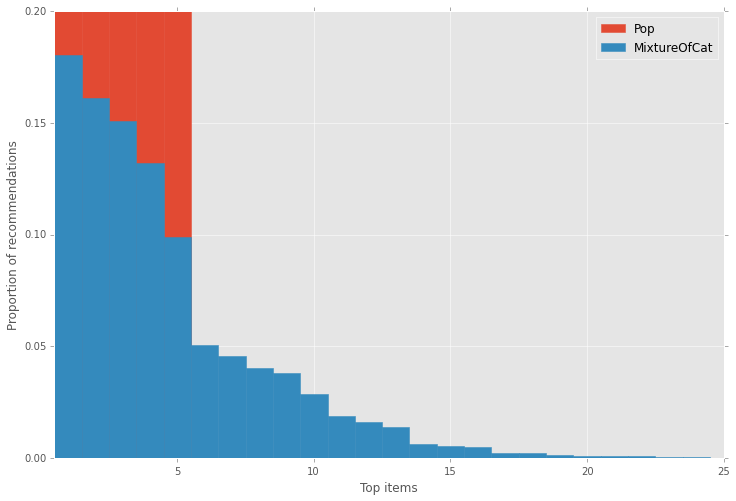

In [153]:
def plot_coverage(user_item_recs):
    rec_item_desc_counts = user_item_recs.groupby('item').size().sort_values(ascending=False).values
    color = next(ax._get_lines.color_cycle)
    ax.bar(.5 + np.arange(len(rec_item_desc_counts)), rec_item_desc_counts / rec_item_desc_counts.sum(dtype='float'), width=1, 
    
           color=color, edgecolor=color)
    
f, ax = plt.subplots(1, figsize=(12, 8))
eval_cut = datetime(2015, 10, 6, 12, 0, 0)

test, recs = evaluate(pop.PopModel, user_events_with_cat, cut_off_dt=eval_cut)
plot_coverage(recs)
print(metrics.prec_and_recall(test, recs))

test, recs = evaluate(history.MixtureOfCategoryModel, user_events_with_cat, cut_off_dt=eval_cut)
plot_coverage(recs)
print(metrics.prec_and_recall(test, recs))

plt.xlim([.5, 25])
plt.xlabel('Top items')
plt.ylabel('Proportion of recommendations')
plt.legend(['Pop', 'MixtureOfCat']);

## Accuracy and conclusions

 * Pop slightly better than MixtureModel :(
 * Probably hard to compete with the front page composition (could we discount it? do we collect this information?)
 * Could user interest be more transient? Like changing week after week?
 * Any other simple models that we should test? I would like to bring in topics from LDA, see if that improves things


In [146]:
n = 15
algo_metrics_over_time = np.zeros((2, 2, n))
eval_cuts = []
for i in range(n):
    eval_cut = datetime(2015, 10, 1, 12, 0, 0) + timedelta(days=i)
    eval_cuts += [eval_cut]
    algo_metrics_over_time[0, :, i] = metrics.prec_and_recall(*
        evaluate(pop.PopModel, user_events_with_cat, cut_off_dt=eval_cut))

    algo_metrics_over_time[1, :, i] = metrics.prec_and_recall(*
        evaluate(history.MixtureOfCategoryModel, user_events_with_cat, cut_off_dt=eval_cut))

4/5995 test/train events from 2/9341 test users
4/5995 test/train events from 2/9341 test users
1124/35854 test/train events from 413/10485 test users
1124/35854 test/train events from 413/10485 test users
2638/67283 test/train events from 1134/8900 test users
2638/67283 test/train events from 1134/8900 test users
4482/96758 test/train events from 2036/10255 test users
4482/96758 test/train events from 2036/10255 test users
8576/134798 test/train events from 3459/13668 test users
8576/134798 test/train events from 3459/13668 test users
12089/183858 test/train events from 4872/15110 test users
12089/183858 test/train events from 4872/15110 test users
15323/244535 test/train events from 6410/16600 test users
15323/244535 test/train events from 6410/16600 test users
17049/299102 test/train events from 7366/15697 test users
17049/299102 test/train events from 7366/15697 test users
19509/355751 test/train events from 7928/15552 test users
19509/355751 test/train events from 7928/15552 test 

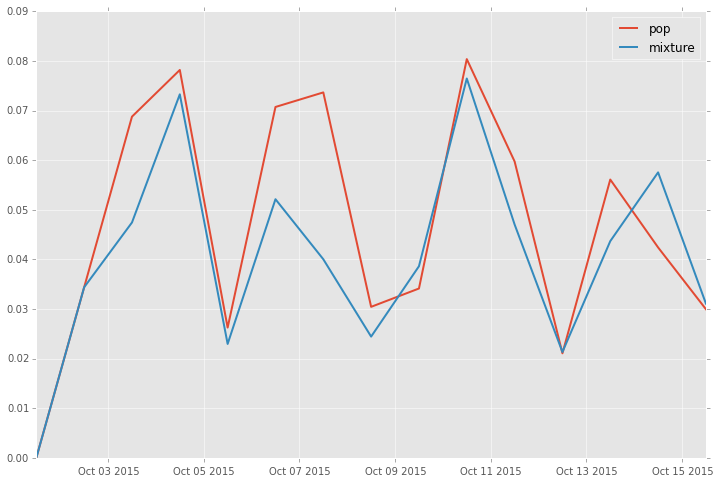

In [151]:
plt.figure(figsize=(12, 8))
plt.plot(eval_cuts, algo_metrics_over_time[0, 0, :], lw=2, label='pop')
plt.plot(eval_cuts, algo_metrics_over_time[1, 0, :], lw=2, label='mixture')
plt.legend();